<font size="5"> <center> <b> Credit Card Default Prediction using a function of Bank Profit as gain function</b> </center> </font>

<p>Ramiro Mejia &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Diego Villacreses</p>
<p>ramiromejiap@gmail.com &emsp;&emsp;&emsp; ddvillacresesz@gmail.com</p>

<hr>

This is a notebook detailing the implementation of six models to maximize a *Bank Revenue* function and compare it to other standard gain and loss functions. We used information of 30,000 Taiwan's customers produced on October 2005, detailed description of the information we used can be found [on the for Machine Learning Repository of University of California, Irvine](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). 

We use as a *Bank Profit* function: $Average Profit_{per costumer} = \frac{ \sum_i(\alpha* True Negative_i - (1-\alpha)*False Negative_i)}{Total True Negative + Total False Negative)}$, where $\alpha$ is a parameter that allow us to impose a relative value of a default client against a non-default. Since we doesn't know $\alpha$ we would train our models with $\alpha = \{1/3, 3/7, 1/2\}$.

This notebook has four sections: i) data loading and handling, ii) exploratory data analysis, iii) modelling, iv) conclusions.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-Data,-change-encoding" data-toc-modified-id="Loading-Data,-change-encoding-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading Data, change encoding</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Custom-score-metric" data-toc-modified-id="Custom-score-metric-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Custom score metric</a></span></li><li><span><a href="#Using-default-hyper-parameters" data-toc-modified-id="Using-default-hyper-parameters-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Using default hyper-parameters</a></span></li><li><span><a href="#Default-Hyper-Parameters-and-Class-Balancing:-SMOTE." data-toc-modified-id="Default-Hyper-Parameters-and-Class-Balancing:-SMOTE.-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Default Hyper-Parameters and Class Balancing: SMOTE.</a></span></li><li><span><a href="#Hyperparameter-Tunning-of-LGBM-with-F1-as-gain-function" data-toc-modified-id="Hyperparameter-Tunning-of-LGBM-with-F1-as-gain-function-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Hyperparameter Tunning of LGBM with F1 as gain function</a></span><ul class="toc-item"><li><span><a href="#Results-summarized" data-toc-modified-id="Results-summarized-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Results summarized</a></span></li><li><span><a href="#Results-analyzed" data-toc-modified-id="Results-analyzed-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Results analyzed</a></span></li><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-3.4.3"><span class="toc-item-num">3.4.3&nbsp;&nbsp;</span>Feature importance</a></span></li></ul></li><li><span><a href="#Hyperparameter-Tunning-LGBM---custom-loss-function" data-toc-modified-id="Hyperparameter-Tunning-LGBM---custom-loss-function-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Hyperparameter Tunning LGBM - custom loss function</a></span><ul class="toc-item"><li><span><a href="#Results-summarized" data-toc-modified-id="Results-summarized-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Results summarized</a></span></li><li><span><a href="#Results-analized" data-toc-modified-id="Results-analized-3.5.2"><span class="toc-item-num">3.5.2&nbsp;&nbsp;</span>Results analized</a></span></li><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-3.5.3"><span class="toc-item-num">3.5.3&nbsp;&nbsp;</span>Feature importance</a></span></li></ul></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

In [1]:
import os
import sys
import eli5
import shap
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, make_scorer,
                             precision_score, recall_score,
                             average_precision_score, auc)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score, cross_validate,
                                     train_test_split, cross_val_predict)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from scipy.stats import lognorm, loguniform, randint
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import roc_curve

In [2]:
#For Kendall Correlation
import scipy.stats as stats

In [3]:
#Plotly geberal graph franewoek
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline as pyo

In [4]:
#To save ML sklearn objects
import pickle

## Loading Data, change encoding

In [5]:
# loading data from UCI ML Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, skiprows=1)

# renaming the target variable
df.rename(columns={"default payment next month": "target"}, inplace=True)

# dropping ID
df.drop(columns='ID', inplace=True)

# Changing numeric encoding to labels
df['SEX'].replace([1, 2], ['Male', 'Female'], inplace=True)

df['MARRIAGE'].replace([1, 2, 3, 0], ['Married', 'Single', 'Other', 'Other'],
                       inplace=True)

df['EDUCATION'].replace([1, 2, 3, 4, 0, 5, 6], 
    ['GraduateSchool', 'University', 'HighSchool', 'Other', 'Other', 'Other','Other'],
                        inplace=True)

In [6]:
# split the data 80/20
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2)
train_df.shape

(24000, 24)

In [7]:
print("Distribution of the target variable - train data:\n",
      train_df["target"].value_counts(normalize=True),
      sep='')
print("Distribution of the target variable - all data:\n",
      df["target"].value_counts(normalize=True),
      sep='')

Distribution of the target variable - train data:
0    0.779125
1    0.220875
Name: target, dtype: float64
Distribution of the target variable - all data:
0    0.7788
1    0.2212
Name: target, dtype: float64


We have class imbalance in the target variable.

## Exploratory Data Analysis

In [8]:
# Separate X and Y for training and testing
X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]

In [9]:
#Compare kendall vs. pearson correlation
#Kendall
l = list(df.columns)
l = len(l)
corr_k = np.zeros([l, l])
corr_k = np.asmatrix(corr_k)
for c1 in range(l):
    for c2 in range(l):
        tau, p_value = stats.kendalltau(df.iloc[:, c1], df.iloc[:, c2])
        tau = round(tau, 3)
        corr_k[c1, c2] = tau

corr_k = pd.DataFrame(corr_k)
corr_k.columns = df.columns
corr_k.index = df.columns
corr_k = corr_k.round(2)
#Pearson
corr = df.corr().round(decimals=2)

In [10]:
fig1 = px.imshow(corr_k.T, color_continuous_scale='viridis', origin='lower', text_auto=True)
fig2 = px.imshow(corr.T, color_continuous_scale='viridis', origin='lower', text_auto=True)
fig1 = fig1.update_layout(title='Matrix correlation - Kendall', height=1000, width = 1000)
fig2 = fig2.update_layout(title='Matrix correlation - Pearson', height=1000, width = 1000)

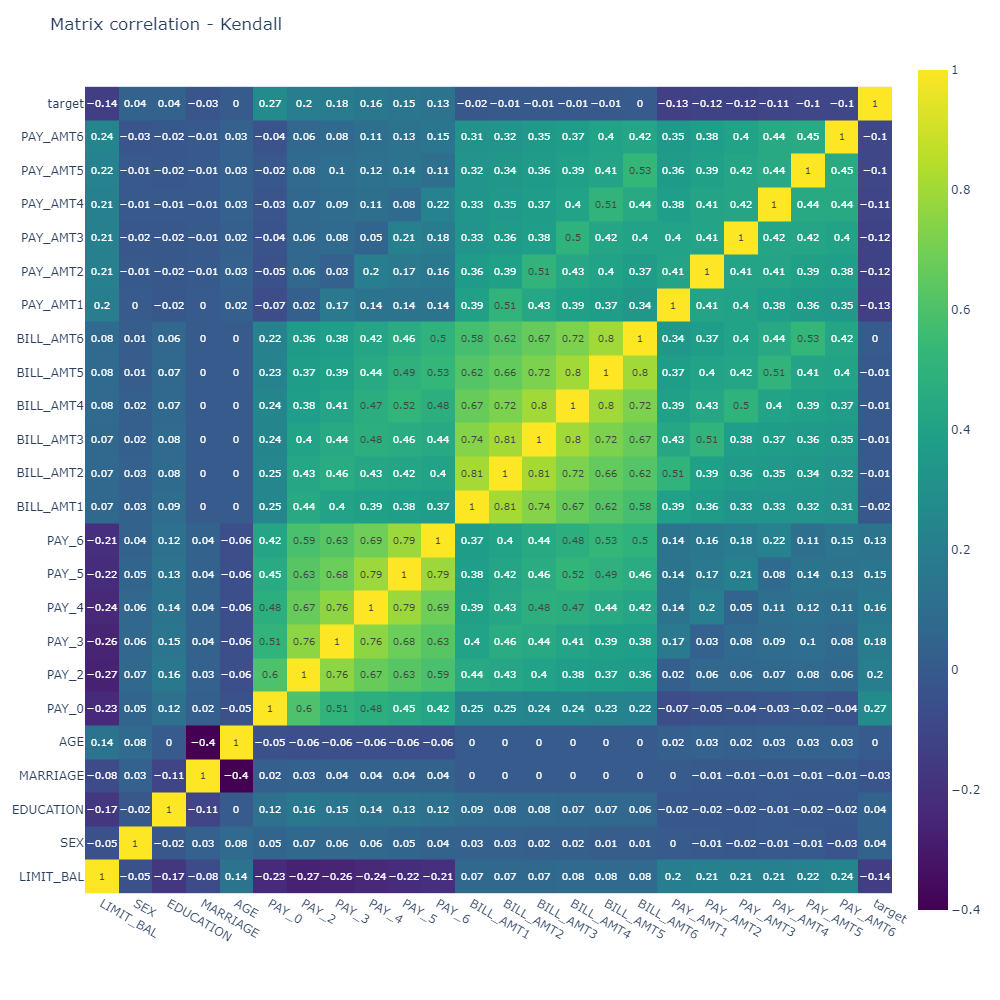

In [11]:
#To see the interactive graph: pyo.iplot(fig1, filename = 'fig1')
fig1.show("png")

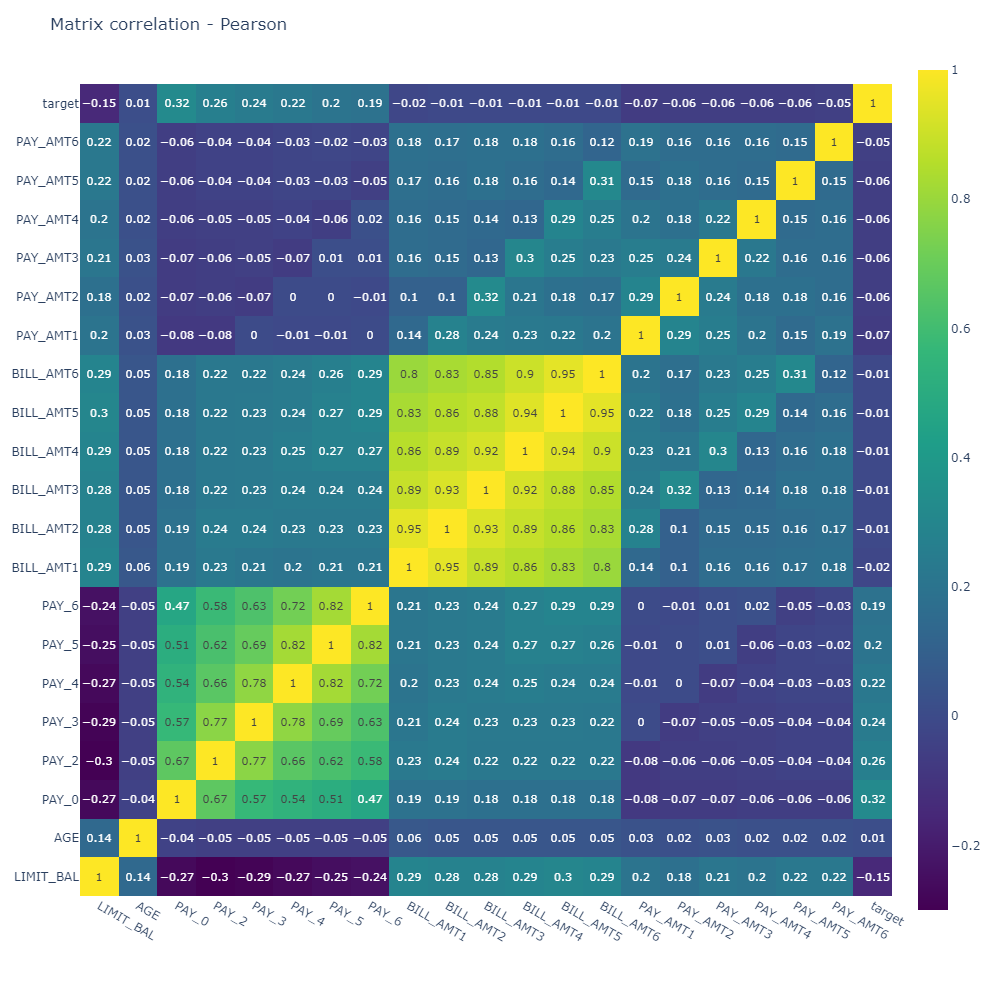

In [12]:
#pyo.iplot(fig2, filename = 'fig2')
fig2.show("png")

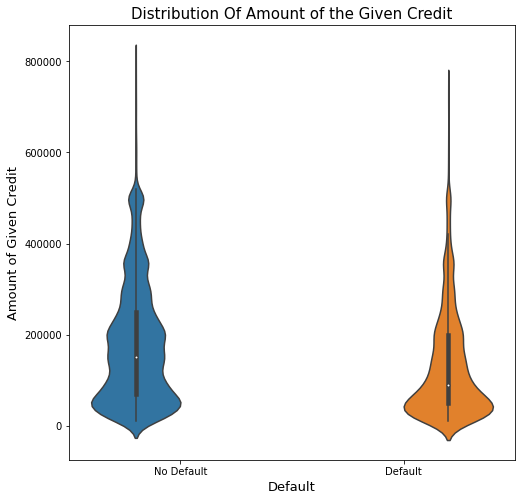

In [13]:
f, ax = plt.subplots(figsize=(8, 8))
violin= sns.violinplot(x="target",
                       y="LIMIT_BAL",
                       hue='target',
               data=train_df)
plt.title('Distribution Of Amount of the Given Credit', fontsize=15)
plt.legend().remove()
plt.xlabel('Default', fontsize=13)
plt.ylabel('Amount of Given Credit', fontsize=13)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'No Default'
labels[1] = 'Default'
ax.set_xticklabels(labels)
plt.show();

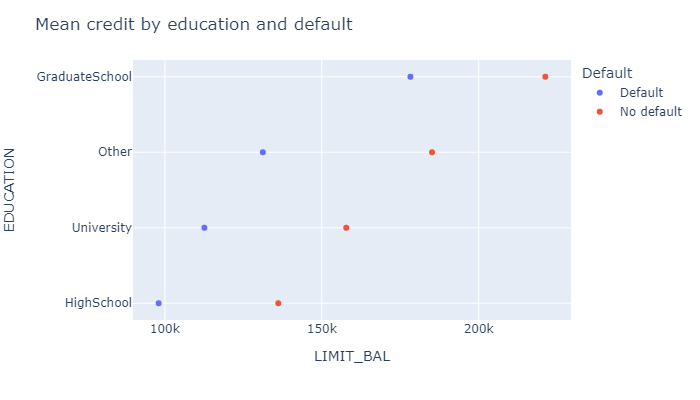

In [14]:
#Mean credit by education and default
tmp = df.loc[:,['LIMIT_BAL','EDUCATION', 'target']].groupby(['target','EDUCATION'],as_index=False).mean('LIMIT_BAL')
cond1 = tmp['target'] == 0
cond2 = tmp['target'] >0
column_name = 'Default'
tmp.loc[cond1, column_name] = 'No default'
tmp.loc[cond2, column_name] = 'Default'
tmp = tmp.sort_values(by = 'LIMIT_BAL',ascending=True)

fig3 = px.scatter(tmp, x="LIMIT_BAL", y="EDUCATION", color="Default")
fig3 = fig3.update_layout(width =700, height=400,title='Mean credit by education and default')

#pyo.iplot(fig3, filename = 'fig3')
fig3.show("png")

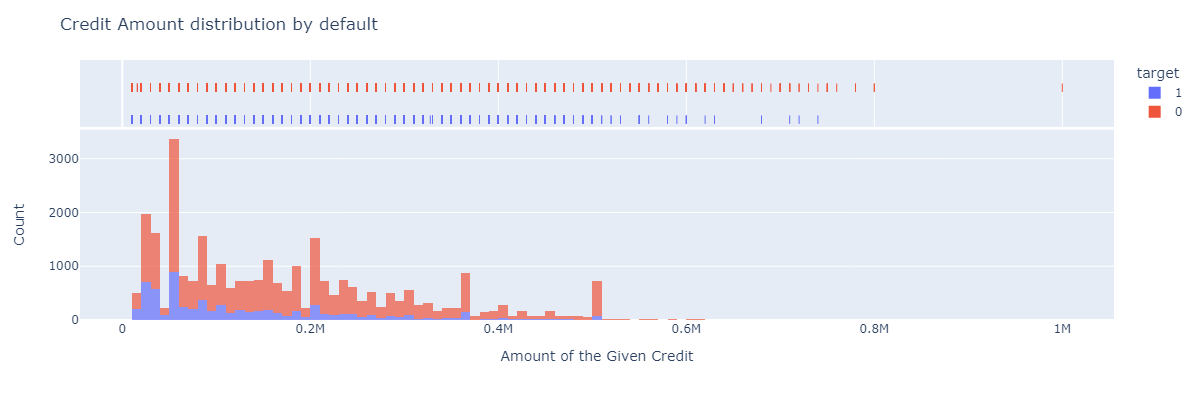

In [15]:
fig4 = px.histogram(df, x="LIMIT_BAL", color="target", marginal="rug", 
                   hover_data=df.columns, nbins=100,
                   opacity=0.7)

fig4 = fig4.update_layout(xaxis_title_text = 'Amount of the Given Credit',
                          yaxis_title_text = 'Count', 
                          title = 'Credit Amount distribution by default',
                          height = 400, width = 1200)

#pyo.iplot(fig4, filename = 'fig4')
fig4.show("png")

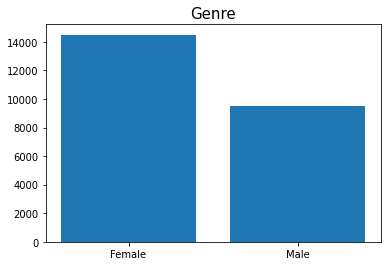

In [16]:
plt.bar(train_df['SEX'].unique().tolist(),
       train_df['SEX'].value_counts().tolist())
plt.title('Genre', fontsize=15);

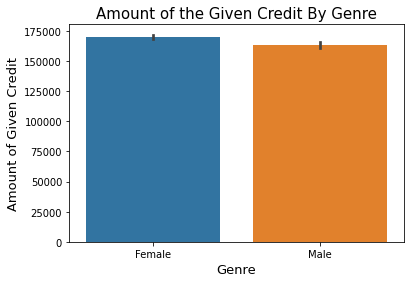

In [17]:
sns.barplot(x = 'SEX',y='LIMIT_BAL',data = df)
plt.xlabel('Genre', fontsize=13)
plt.ylabel('Amount of Given Credit', fontsize=13)
plt.title('Amount of the Given Credit By Genre', fontsize=15)
plt.show();

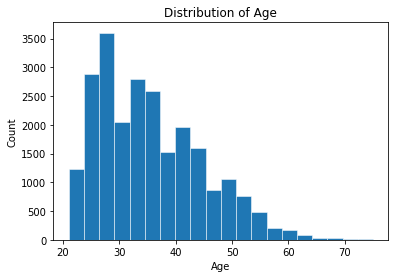

In [18]:
fig, ax = plt.subplots()
ax.hist(train_df['AGE'], bins=20, linewidth=0.5, edgecolor="white")
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age')
plt.show();

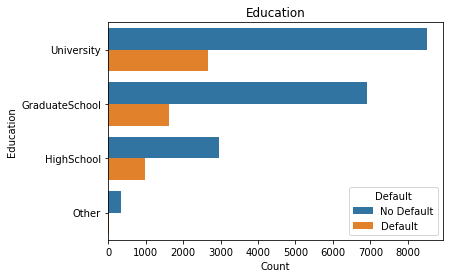

In [19]:
fig, ax = plt.subplots()
ax = sns.countplot(y="EDUCATION", hue="target", data=train_df)
plt.xlabel('Count')
plt.ylabel('Education')
plt.title('Education')
plt.legend(title='Default', labels = ['No Default','Default'])
plt.show();

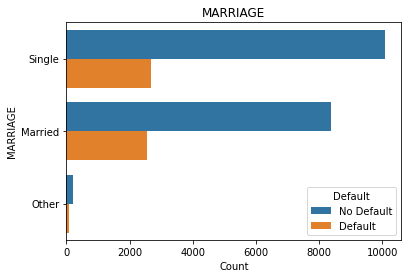

In [20]:
fig, ax = plt.subplots()
ax = sns.countplot(y="MARRIAGE", hue="target", data=train_df)
plt.xlabel('Count')
plt.ylabel('MARRIAGE')
plt.title('MARRIAGE')
plt.legend(title='Default', labels = ['No Default','Default'])
plt.show();

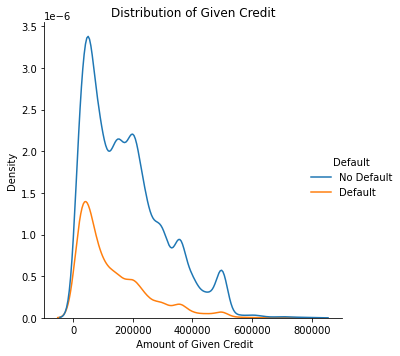

In [21]:
ax = sns.displot(x="LIMIT_BAL", hue="target", data=train_df, kind="kde")
ax.set(xlabel=' Amount of Given Credit', title='Distribution of Given Credit')
ax._legend.set_title('Default')
new_labels = ['No Default', 'Default']
for t, l in zip(ax._legend.texts, new_labels):
    t.set_text(l)
sns.move_legend(ax, "center right")

## Modelling 

In [22]:
# Separate X and Y for training and testing 
X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]

In [23]:
## Code attribution: UBC-MDS DSCI-571 Varada Kolhatkar 

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, cv = 10, **kwargs)
    predicts = cross_val_predict(model, X_train, y_train, cv = 10)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    res = pd.Series(data=out_col, index=mean_scores.index)
    return [res,predicts] 

In [24]:
# Preprocessing and transformations

numeric_features = ["LIMIT_BAL", "AGE",
                    "PAY_0", "PAY_2",
                    "PAY_3", "PAY_4",
                    "PAY_5", "PAY_6",
                    'BILL_AMT1', 'BILL_AMT2',
                    'BILL_AMT3', 'BILL_AMT4',
                    'BILL_AMT5', 'BILL_AMT6',
                    'PAY_AMT1', 'PAY_AMT2',
                    'PAY_AMT3', 'PAY_AMT4',
                    'PAY_AMT5', 'PAY_AMT6']

categorical_features = ["MARRIAGE"]

binary_features = ["SEX"]

ordinal_features = ["EDUCATION"]

education_levels = ['Other',  'HighSchool', 'University', 'GraduateSchool']


# preprocessor

preprocessor = make_column_transformer(

    (StandardScaler(), numeric_features),

    (
        OrdinalEncoder(categories=[education_levels], dtype=int),
        ordinal_features
    ),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (
        OneHotEncoder(handle_unknown="ignore", sparse=False),
        categorical_features
    )

)

### Custom score metric

In [25]:
#Custom scorer for scikit-learn, resources:
    #https://scikit-learn.org/stable/modules/model_evaluation.html#defining-your-scoring-strategy-from-metric-functions
    #https://stackoverflow.com/questions/32401493/how-to-create-customize-your-own-scorer-function-in-scikit-learn
def my_custom_loss_func(y_true, y_pred):
    diff = np.abs(y_true - y_pred).max()
    return np.log1p(diff)
#Banks earnings:
def bank_earnings_f1(y_true, y_pred):
    tmp_array =  np.array([y_true,y_pred])
    tmp_df = pd.DataFrame(tmp_array.T, columns = ['true','pred'])
    tmp_df['n'] = 1
    tmp_df_g = tmp_df.groupby(['true','pred'],as_index=False).sum('n')
    #earnings = alpha*true_negative - (1-alpha)*false_negative
    alpha = 1/3
    cond1 = (tmp_df_g['true'] == 1) & (tmp_df_g['pred'] == 1)
    cond2 = (tmp_df_g['true'] == 1) & (tmp_df_g['pred'] == 0)
    cond3 = (tmp_df_g['true'] == 0) & (tmp_df_g['pred'] == 0)
    cond4 = (tmp_df_g['true'] == 0) & (tmp_df_g['pred'] == 1)
    true_positive = tmp_df_g.loc[cond1]['n'].iloc[0]
    false_negative = tmp_df_g.loc[cond2]['n'].iloc[0]
    true_negative = tmp_df_g.loc[cond3]['n'].iloc[0]
    false_positive = tmp_df_g.loc[cond4]['n'].iloc[0]
    profit = (alpha*true_negative - (1-alpha)*false_negative)/(true_negative + false_negative)
    return profit

def bank_earnings_f2(y_true, y_pred):
    tmp_array =  np.array([y_true,y_pred])
    tmp_df = pd.DataFrame(tmp_array.T, columns = ['true','pred'])
    tmp_df['n'] = 1
    tmp_df_g = tmp_df.groupby(['true','pred'],as_index=False).sum('n')
    alpha = 3/7
    cond1 = (tmp_df_g['true'] == 1) & (tmp_df_g['pred'] == 1)
    cond2 = (tmp_df_g['true'] == 1) & (tmp_df_g['pred'] == 0)
    cond3 = (tmp_df_g['true'] == 0) & (tmp_df_g['pred'] == 0)
    cond4 = (tmp_df_g['true'] == 0) & (tmp_df_g['pred'] == 1)
    true_positive = tmp_df_g.loc[cond1]['n'].iloc[0]
    false_negative = tmp_df_g.loc[cond2]['n'].iloc[0]
    true_negative = tmp_df_g.loc[cond3]['n'].iloc[0]
    false_positive = tmp_df_g.loc[cond4]['n'].iloc[0]
    profit = (alpha*true_negative - (1-alpha)*false_negative)/(true_negative + false_negative)
    return profit

def bank_earnings_f3(y_true, y_pred):
    tmp_array =  np.array([y_true,y_pred])
    tmp_df = pd.DataFrame(tmp_array.T, columns = ['true','pred'])
    tmp_df['n'] = 1
    tmp_df_g = tmp_df.groupby(['true','pred'],as_index=False).sum('n')
    #earnings = alpha*true_negative - (1-alpha)*false_negative
    alpha = 1/2
    cond1 = (tmp_df_g['true'] == 1) & (tmp_df_g['pred'] == 1)
    cond2 = (tmp_df_g['true'] == 1) & (tmp_df_g['pred'] == 0)
    cond3 = (tmp_df_g['true'] == 0) & (tmp_df_g['pred'] == 0)
    cond4 = (tmp_df_g['true'] == 0) & (tmp_df_g['pred'] == 1)
    true_positive = tmp_df_g.loc[cond1]['n'].iloc[0]
    false_negative = tmp_df_g.loc[cond2]['n'].iloc[0]
    true_negative = tmp_df_g.loc[cond3]['n'].iloc[0]
    false_positive = tmp_df_g.loc[cond4]['n'].iloc[0]
    profit = (alpha*true_negative - (1-alpha)*false_negative)/(true_negative + false_negative)
    return profit

bank_earnings1 = make_scorer(bank_earnings_f1, greater_is_better=True)
bank_earnings2 = make_scorer(bank_earnings_f2, greater_is_better=True)
bank_earnings3 = make_scorer(bank_earnings_f3, greater_is_better=True)

In [26]:
# evalution metric for scoring
f1_micro = make_scorer(f1_score, average="micro")

scoring = {
    "earnings, a=1/3": bank_earnings1,
    "earnings, a=3/7": bank_earnings2,
    "earnings, a=1/2": bank_earnings3,
    "f1": f1_micro,
    "recall": "recall",
    "precision": "precision",
    'roc_auc': 'roc_auc'
}

### Using default hyper-parameters

In [27]:
# Dictionary of Results and Predictions
results = {}
preds = {}

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVC": SVC(random_state=123),
    "Random Forest": RandomForestClassifier(random_state=123),
    "XGBoost": XGBClassifier(random_state=123, eval_metric="logloss",
                             verbosity=0, use_label_encoder=False,
                             class_weight="balanced", nthread = -1),
    "LightGBM": LGBMClassifier(random_state=123),
    "CatBoost": CatBoostClassifier(verbose=0,
                                   random_state=123)
}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    tmp = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring
    )
    results[name] = tmp[0]
    preds[name] = tmp[1]

In [28]:
results_3_2 = pd.DataFrame(results).T

In [29]:
results_3_2

,fit_time,score_time,"test_earnings, a=1/3","train_earnings, a=1/3","test_earnings, a=3/7","train_earnings, a=3/7","test_earnings, a=1/2","train_earnings, a=1/2",test_f1,train_f1,test_recall,train_recall,test_precision,train_precision,test_roc_auc,train_roc_auc
Logistic Regression,0.214 (+/- 0.007),0.027 (+/- 0.001),0.151 (+/- 0.003),0.151 (+/- 0.001),0.246 (+/- 0.003),0.247 (+/- 0.001),0.318 (+/- 0.003),0.318 (+/- 0.001),0.810 (+/- 0.006),0.811 (+/- 0.001),0.234 (+/- 0.013),0.236 (+/- 0.006),0.720 (+/- 0.048),0.720 (+/- 0.003),0.721 (+/- 0.011),0.723 (+/- 0.002)
SVC,18.160 (+/- 1.803),4.107 (+/- 0.046),0.166 (+/- 0.004),0.169 (+/- 0.001),0.262 (+/- 0.004),0.265 (+/- 0.001),0.333 (+/- 0.004),0.336 (+/- 0.001),0.819 (+/- 0.006),0.824 (+/- 0.001),0.321 (+/- 0.019),0.335 (+/- 0.006),0.695 (+/- 0.033),0.717 (+/- 0.006),0.720 (+/- 0.011),0.778 (+/- 0.002)
Random Forest,5.021 (+/- 0.100),0.126 (+/- 0.006),0.173 (+/- 0.004),0.333 (+/- 0.000),0.268 (+/- 0.004),0.428 (+/- 0.000),0.339 (+/- 0.004),0.500 (+/- 0.000),0.816 (+/- 0.006),1.000 (+/- 0.000),0.363 (+/- 0.017),0.998 (+/- 0.000),0.651 (+/- 0.026),0.999 (+/- 0.000),0.760 (+/- 0.017),1.000 (+/- 0.000)
XGBoost,0.904 (+/- 0.079),0.045 (+/- 0.004),0.171 (+/- 0.002),0.220 (+/- 0.002),0.267 (+/- 0.002),0.316 (+/- 0.002),0.338 (+/- 0.002),0.387 (+/- 0.002),0.814 (+/- 0.006),0.887 (+/- 0.002),0.356 (+/- 0.009),0.560 (+/- 0.009),0.644 (+/- 0.031),0.890 (+/- 0.006),0.762 (+/- 0.014),0.945 (+/- 0.004)
LightGBM,0.184 (+/- 0.012),0.039 (+/- 0.003),0.173 (+/- 0.003),0.188 (+/- 0.001),0.268 (+/- 0.003),0.283 (+/- 0.001),0.340 (+/- 0.003),0.355 (+/- 0.001),0.820 (+/- 0.006),0.845 (+/- 0.002),0.361 (+/- 0.015),0.422 (+/- 0.006),0.675 (+/- 0.031),0.772 (+/- 0.006),0.777 (+/- 0.013),0.886 (+/- 0.002)
CatBoost,6.900 (+/- 0.535),0.059 (+/- 0.007),0.173 (+/- 0.004),0.196 (+/- 0.001),0.268 (+/- 0.004),0.292 (+/- 0.001),0.339 (+/- 0.004),0.363 (+/- 0.001),0.819 (+/- 0.007),0.856 (+/- 0.001),0.359 (+/- 0.016),0.458 (+/- 0.006),0.667 (+/- 0.031),0.806 (+/- 0.003),0.778 (+/- 0.015),0.892 (+/- 0.001)


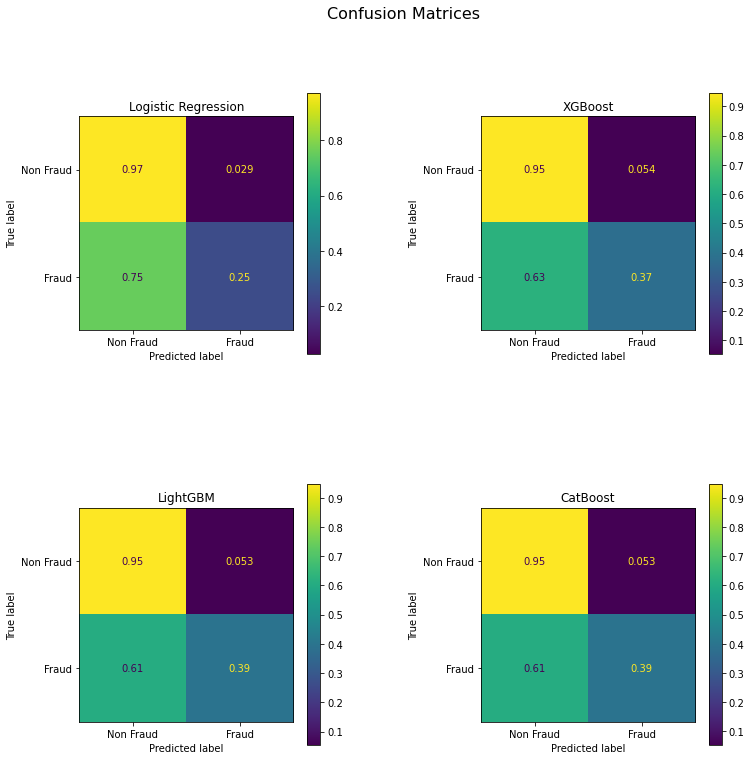

In [30]:
# Building Confusion Matrix

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,
                                             figsize=(12, 12))

fig.subplots_adjust(wspace = 0.5, hspace = 0.5 )

fig.suptitle("Confusion Matrices", horizontalalignment='center',
             fontsize=16)

axes = [ax1, None, None, ax2, ax3, ax4 ]
labels = ["Non Fraud", "Fraud"]

for (k, m), ax in zip(models.items(), axes):

    if (k == "Random Forest" or k == "SVC"):
        continue

    pipe = make_pipeline(preprocessor, m)
    pipe.fit(X_train, y_train);

    ConfusionMatrixDisplay.from_estimator(

        pipe, X_test, y_test, ax=ax, display_labels=labels,
        normalize='true'
    )
    ax.set_title(f"{k}")

fig;

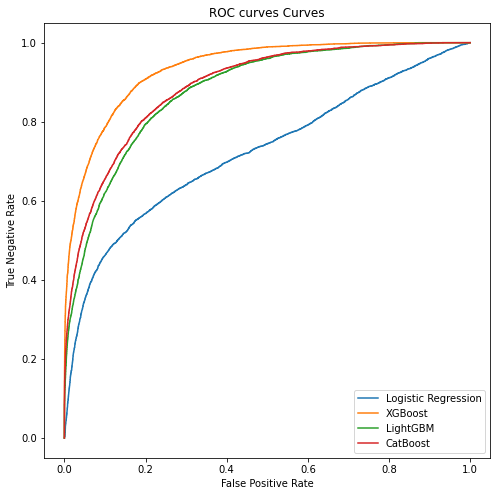

In [31]:
f, ax = plt.subplots(figsize=(8, 8))

for k, m in models.items():

    if (k == "Random Forest" or k == "SVC"):
        continue

    pipe = make_pipeline(preprocessor, m)
    pipe.fit(X_train, y_train);

    precision, recall, thresholds = roc_curve(
        y_train, pipe.predict_proba(X_train)[:, 1])

    plt.plot(precision, recall, label=k)

plt.title("ROC curves Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Negative Rate")
plt.legend(loc="best");

### Default Hyper-Parameters and Class Balancing: SMOTE. 

In [32]:
results_smote = {}
preds_smote = {}
for name, model in models.items():
    pipe = make_imb_pipeline(preprocessor,
                             SMOTE(),
                             model)
    tmp = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring
    )
    results_smote[name] = tmp[0]
    preds_smote[name] = tmp[1]

In [33]:
results_3_3 = pd.DataFrame(results_smote).T
results_3_3

,fit_time,score_time,"test_earnings, a=1/3","train_earnings, a=1/3","test_earnings, a=3/7","train_earnings, a=3/7","test_earnings, a=1/2","train_earnings, a=1/2",test_f1,train_f1,test_recall,train_recall,test_precision,train_precision,test_roc_auc,train_roc_auc
Logistic Regression,0.702 (+/- 0.027),0.030 (+/- 0.002),0.206 (+/- 0.004),0.207 (+/- 0.001),0.302 (+/- 0.004),0.302 (+/- 0.001),0.373 (+/- 0.004),0.374 (+/- 0.001),0.677 (+/- 0.009),0.677 (+/- 0.004),0.649 (+/- 0.013),0.651 (+/- 0.006),0.369 (+/- 0.009),0.369 (+/- 0.004),0.722 (+/- 0.011),0.725 (+/- 0.002)
SVC,48.630 (+/- 1.269),9.583 (+/- 0.088),0.206 (+/- 0.006),0.214 (+/- 0.001),0.301 (+/- 0.006),0.309 (+/- 0.001),0.373 (+/- 0.006),0.380 (+/- 0.001),0.776 (+/- 0.011),0.786 (+/- 0.002),0.570 (+/- 0.021),0.597 (+/- 0.005),0.495 (+/- 0.021),0.514 (+/- 0.004),0.757 (+/- 0.016),0.798 (+/- 0.002)
Random Forest,8.494 (+/- 0.132),0.135 (+/- 0.006),0.186 (+/- 0.005),0.333 (+/- 0.000),0.281 (+/- 0.005),0.428 (+/- 0.000),0.353 (+/- 0.005),0.500 (+/- 0.000),0.797 (+/- 0.008),1.000 (+/- 0.000),0.455 (+/- 0.019),0.999 (+/- 0.000),0.548 (+/- 0.022),0.999 (+/- 0.000),0.755 (+/- 0.016),1.000 (+/- 0.000)
XGBoost,1.733 (+/- 0.076),0.041 (+/- 0.003),0.177 (+/- 0.004),0.221 (+/- 0.001),0.272 (+/- 0.004),0.317 (+/- 0.001),0.343 (+/- 0.004),0.388 (+/- 0.001),0.810 (+/- 0.006),0.879 (+/- 0.002),0.391 (+/- 0.015),0.570 (+/- 0.005),0.608 (+/- 0.022),0.828 (+/- 0.007),0.756 (+/- 0.012),0.927 (+/- 0.003)
LightGBM,0.718 (+/- 0.036),0.038 (+/- 0.003),0.181 (+/- 0.003),0.193 (+/- 0.002),0.276 (+/- 0.003),0.288 (+/- 0.002),0.348 (+/- 0.003),0.360 (+/- 0.002),0.812 (+/- 0.007),0.832 (+/- 0.002),0.414 (+/- 0.012),0.460 (+/- 0.008),0.613 (+/- 0.030),0.675 (+/- 0.007),0.769 (+/- 0.013),0.843 (+/- 0.002)
CatBoost,9.518 (+/- 1.067),0.066 (+/- 0.011),0.176 (+/- 0.003),0.200 (+/- 0.001),0.272 (+/- 0.003),0.295 (+/- 0.001),0.343 (+/- 0.003),0.366 (+/- 0.001),0.815 (+/- 0.006),0.851 (+/- 0.001),0.384 (+/- 0.015),0.480 (+/- 0.006),0.637 (+/- 0.024),0.758 (+/- 0.004),0.769 (+/- 0.015),0.889 (+/- 0.001)


### Hyperparameter Tunning of LGBM with F1 as gain function

In [34]:
# Light GBM
pipe_lgbm = make_imb_pipeline(preprocessor, LGBMClassifier(random_state=123))

params = {
    "lgbmclassifier__boosting_type": ['gbdt', 'dart'],
    "lgbmclassifier__num_leaves ": randint(low=10, high=2000),
    "lgbmclassifier__n_estimators":randint(low=10, high=2000),
    "lgbmclassifier__class_weight": [None, "balanced"]
}

search = RandomizedSearchCV(
    pipe_lgbm,
    params,
    verbose=0,
    n_jobs=-1,
    n_iter=50,
    return_train_score=True,
    scoring= f1_micro,
    random_state=123,
)

search.fit(X_train, y_train);

[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 960


In [35]:
print("Best score F1-micro: %0.3f" % (search.best_score_))

Best score F1-micro: 0.821


In [36]:
b_type = search.best_params_['lgbmclassifier__boosting_type']
n_estimators= search.best_params_['lgbmclassifier__n_estimators']
num_leaves= search.best_params_['lgbmclassifier__num_leaves ']

In [37]:
pipe_lgbm_best = make_imb_pipeline(preprocessor,
                                   LGBMClassifier(random_state=123,
                                                  boosting_type=b_type,
                                                  n_estimators= n_estimators,
                                                  num_leaves= num_leaves))
pipe_lgbm_best.fit(X_train, y_train);

#### Results summarized

In [38]:
print(
    f"Grid Search best model validation score f1 score: {round(search.best_score_, 3)}"
)
print(f"Test f1 score - micro-average:  {round(f1_score(y_test, pipe_lgbm_best.predict(X_test), average= 'micro'), 3)}")
print(f"Test Accuracy score: {round(accuracy_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Test Recall score: {round(recall_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Test ROC_AUC score: {round(roc_auc_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Test precision score: {round(precision_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")

Grid Search best model validation score f1 score: 0.821
Test f1 score - micro-average:  0.814
Test Accuracy score: 0.814
Test Recall score: 0.394
Test ROC_AUC score: 0.664
Test precision score: 0.631


In [47]:
print(f"Bank Profit alpha=1/3: {round(bank_earnings_f1(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Bank Profit alpha=3/7: {round(bank_earnings_f2(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Bank Profit alpha=1/2: {round(bank_earnings_f3(y_test, pipe_lgbm_best.predict(X_test)), 3)}")

Bank Profit alpha=1/3: 0.177
Bank Profit alpha=3/7: 0.272
Bank Profit alpha=1/2: 0.343


#### Results analyzed

- If we compare this profits results with subsections 3.2 and 3.3 we can see that using F1-score as a loss function doesn't improve profit results under any alpha. 

#### Feature importance

In [48]:
binary_names = pipe_lgbm_best.named_steps["columntransformer"].named_transformers_['onehotencoder-1'].get_feature_names_out().tolist()
categorical_names = pipe_lgbm_best.named_steps["columntransformer"].named_transformers_['onehotencoder-2'].get_feature_names_out().tolist()
feature_names = numeric_features + ordinal_features + binary_names + categorical_names

In [49]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)


X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

lgbm_explainer = shap.TreeExplainer(pipe_lgbm_best.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)

C:\Users\Diego\miniconda3\lib\site-packages\shap\explainers\_tree.py:351: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



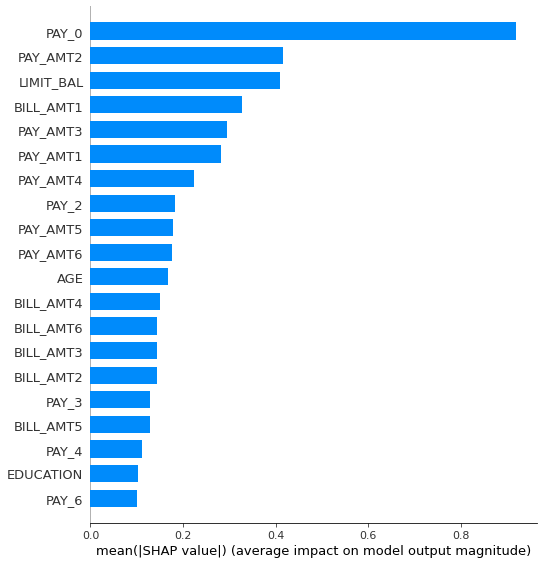

In [50]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc, plot_type="bar")

### Hyperparameter Tunning LGBM - custom loss function

In [51]:
from scipy.stats import uniform

In [72]:
# Light GBM
#params0 = {'num_iterations': 1000, 'early_stopping_round': 10}
pipe_lgbm = make_imb_pipeline(preprocessor, LGBMClassifier(random_state=123,**params0))

params = {
    "lgbmclassifier__boosting_type":  ['gbdt', 'dart'],
    "lgbmclassifier__num_leaves ": randint(low=5, high=5000),
    "lgbmclassifier__n_estimators":randint(low=5, high=5000),
    #"lgbmclassifier__class_weight": [None, "balanced"],
    #"lgbmclassifier__num_iterations" : [1000,1001],
    #"lgbmclassifier__early_stopping_round" : [50,51],
    "lgbmclassifier__max_bin": randint(low=5, high=1000),
    "lgbmclassifier__eta": uniform(0, 0.9),
    "lgbmclassifier__min_gain_to_split": uniform(0, 0.5)
    
}
#min_gain_to_split 
# max_delta_step 
search = RandomizedSearchCV(
    pipe_lgbm,
    params,
    verbose=0,
    n_jobs=-1,
    n_iter=100,
    return_train_score=True,
    scoring= bank_earnings1,
    random_state=123,
)

In [67]:
search.fit(X_train, y_train);

[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 3491
[LightGBM] [Warning] min_gain_to_split is set=0.12030526699836105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12030526699836105
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3366523310390526 will be ignored. Current value: learning_rate=0.1


In [85]:
search.best_params_

{'lgbmclassifier__boosting_type': 'dart',
 'lgbmclassifier__eta': 0.3366523310390526,
 'lgbmclassifier__max_bin': 328,
 'lgbmclassifier__min_gain_to_split': 0.12030526699836105,
 'lgbmclassifier__n_estimators': 121,
 'lgbmclassifier__num_leaves ': 3491}

In [54]:
# save the model to disk
filename = 'LightGBM_100i_9HP_LossFCustAlpha1over3.sav'
pickle.dump(search, open(filename, 'wb'))

In [77]:
# load the model from disk
search = pickle.load(open(filename, 'rb'))

In [179]:
# Preprocessing and transformations
numeric_features = ["LIMIT_BAL", "AGE",
                    "PAY_0", "PAY_2",
                    "PAY_3", "PAY_4",
                    "PAY_5", "PAY_6",
                    'BILL_AMT1', 'BILL_AMT2',
                    'BILL_AMT3', 'BILL_AMT4',
                    'BILL_AMT5', 'BILL_AMT6',
                    'PAY_AMT1', 'PAY_AMT2',
                    'PAY_AMT3', 'PAY_AMT4',
                    'PAY_AMT5', 'PAY_AMT6']
categorical_features = ["MARRIAGE"]
binary_features = ["SEX"]
ordinal_features = ["EDUCATION"]
education_levels = ['Other',  'HighSchool', 'University', 'GraduateSchool']

# preprocessor
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (
        OrdinalEncoder(categories=[education_levels], dtype=int),
        ordinal_features
    ),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (
        OneHotEncoder(handle_unknown="ignore", sparse=False),
        categorical_features
    )

)

pipe_lgbm_base = make_imb_pipeline(preprocessor,LGBMClassifier(random_state=124))
pipe_lgbm_base.fit(X_train, y_train);

In [212]:
pipe_lgbm_best = make_imb_pipeline(preprocessor,
                                   LGBMClassifier(
                                       random_state=123,
                                       boosting_type = search.best_params_['lgbmclassifier__boosting_type'],
                                       learning_rate = search.best_params_['lgbmclassifier__eta'],
                                       max_bin = search.best_params_['lgbmclassifier__max_bin'],
                                       #min_split_gain = search.best_params_['lgbmclassifier__min_gain_to_split'],
                                       n_estimators = search.best_params_['lgbmclassifier__n_estimators'],
                                       num_leaves = search.best_params_['lgbmclassifier__num_leaves ']
                                   ))
pipe_lgbm_best.fit(X_train, y_train);

#### Results summarized

In [189]:
print("Basic LGBM results")
print(f"Test f1 score - micro-average:  {round(f1_score(y_test, pipe_lgbm_base.predict(X_test), average= 'micro'), 4)}")
print(f"Test Accuracy score: {round(accuracy_score(y_test, pipe_lgbm_base.predict(X_test)), 4)}")
print(f"Test Recall score: {round(recall_score(y_test, pipe_lgbm_base.predict(X_test)), 4)}")
print(f"Test ROC_AUC score: {round(roc_auc_score(y_test, pipe_lgbm_base.predict(X_test)), 4)}")
print(f"Test precision score: {round(precision_score(y_test, pipe_lgbm_base.predict(X_test)), 4)}")

Basic LGBM results
Test f1 score - micro-average:  0.8237
Test Accuracy score: 0.8237
Test Recall score: 0.394
Test ROC_AUC score: 0.6703
Test precision score: 0.6787


In [190]:
print(f"Bank Profit alpha=1/3: {round(bank_earnings_f1(y_test, pipe_lgbm_base.predict(X_test)), 4)}")
print(f"Bank Profit alpha=3/7: {round(bank_earnings_f2(y_test, pipe_lgbm_base.predict(X_test)), 4)}")
print(f"Bank Profit alpha=1/2: {round(bank_earnings_f3(y_test, pipe_lgbm_base.predict(X_test)), 4)}")

Bank Profit alpha=1/3: 0.1785
Bank Profit alpha=3/7: 0.2737
Bank Profit alpha=1/2: 0.3452


In [213]:
print("LGBM results using Hyperparameter Tunning")
print(
    f"Grid Search best model validation score f1 score: {round(search.best_score_, 4)}"
)
print(f"Test f1 score - micro-average:  {round(f1_score(y_test, pipe_lgbm_best.predict(X_test), average= 'micro'), 4)}")
print(f"Test Accuracy score: {round(accuracy_score(y_test, pipe_lgbm_best.predict(X_test)), 4)}")
print(f"Test Recall score: {round(recall_score(y_test, pipe_lgbm_best.predict(X_test)), 4)}")
print(f"Test ROC_AUC score: {round(roc_auc_score(y_test, pipe_lgbm_best.predict(X_test)), 4)}")
print(f"Test precision score: {round(precision_score(y_test, pipe_lgbm_best.predict(X_test)), 4)}")


LGBM results using Hyperparameter Tunning
Grid Search best model validation score f1 score: 0.173
Test f1 score - micro-average:  0.8118
Test Accuracy score: 0.8118
Test Recall score: 0.3933
Test ROC_AUC score: 0.6624
Test precision score: 0.622


In [214]:
print(f"Bank Profit alpha=1/3: {round(bank_earnings_f1(y_test, pipe_lgbm_best.predict(X_test)), 4)}")
print(f"Bank Profit alpha=3/7: {round(bank_earnings_f2(y_test, pipe_lgbm_best.predict(X_test)), 4)}")
print(f"Bank Profit alpha=1/2: {round(bank_earnings_f3(y_test, pipe_lgbm_best.predict(X_test)), 4)}")

Bank Profit alpha=1/3: 0.1762
Bank Profit alpha=3/7: 0.2715
Bank Profit alpha=1/2: 0.3429


#### Results analized

We can see that after a considerable Hyperparameter Tunning LGMB using an specific function for Profits doesn't give better results. This could be expected when the real model is simple and doesn't require more complex models. On the other hand those results could have less variance under cross-validation, a computation that should be analyzed.

#### Feature importance

In [131]:
binary_names = pipe_lgbm_best.named_steps["columntransformer"].named_transformers_['onehotencoder-1'].get_feature_names_out().tolist()

In [132]:
categorical_names = pipe_lgbm_best.named_steps["columntransformer"].named_transformers_['onehotencoder-2'].get_feature_names_out().tolist()

In [133]:
feature_names = numeric_features + ordinal_features + binary_names + categorical_names

In [134]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)


X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

lgbm_explainer = shap.TreeExplainer(pipe_lgbm_best.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)

C:\Users\Diego\miniconda3\lib\site-packages\shap\explainers\_tree.py:351: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



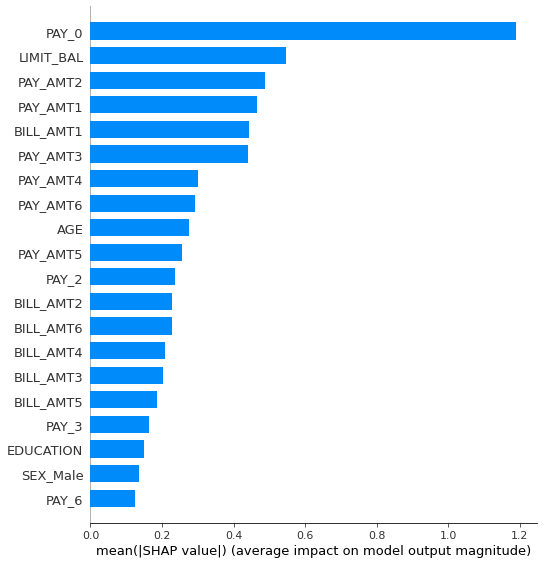

In [135]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc, plot_type="bar")

## Conclusions

The usage of specific loss functions to hand-tailor model selection and Hyperparameter Tunning could lead to huge improvement under certain circumstances. We haven't found significant improvement using credit card default data from [on the for Machine Learning Repository of University of California, Irvine](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients), but more studies are needed to understand the benefits of this kind of functions.